<h1><center><font size="6">Tutorial for Classification</font></center></h1>

<h2><center><font size="4">Dataset used: Titanic - Machine Learning from Disaster</font></center></h2>

<br>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/RMS_Titanic_3.jpg/640px-RMS_Titanic_3.jpg" width="450"></img>

In [1]:
import datetime
print("Last updated:")
print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M"))

Last updated:
2020-02-09 09:20




# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Prepare the data analysis</a>  
 - <a href='#21'>Load packages</a>  
 - <a href='#22'>Load the data</a>   
- <a href='#3'>Data exploration</a>   
 - <a href='#31'>Check for missing data</a>  
 - <a href='#32'>Sex, Age, SibSp, Parch</a>   
 - <a href='#33'>Fare, Embarked, Pclass</a>  
 - <a href='#34'>Ticket, Cabin, Name</a>   
 - <a href='#35'>Multiple features visualization</a>   
 - <a href='#36'>Imputation of missing data</a>   
- <a href='#4'>Feature engineering</a>
 - <a href='#41'>Extract Title from Name</a>
 - <a href='#42'>Build families</a>
 - <a href='#43'>Extract Deck from Ticket</a>  
 - <a href='#44'>Estimate age</a>  
 - <a href='#45'>More features engineering</a>  
- <a href='#5'>Predictive model for survival</a>
 - <a href='#50'>Split the data</a>  
 - <a href='#51'>Build a baseline model</a>  
 - <a href='#52'>Model evaluation</a>    
 - <a href='#53'>Model refinement</a> 
 - <a href='#54'>Submission</a>  
 - <a href='#55'>Hyperparameters optimization</a>
 - <a href='#56'>Submission (model with hyperparameters optimization)</a>  
- <a href='#6'>Model ensambling</a>
 - <a href='#61'>Create the ensamble framework</a>
 - <a href='#62'>Create the Out-Of-Fold Predictions</a>
 - <a href='#63'>Train the first level models</a>
 - <a href='#64'>Correlation of the results</a>
 - <a href='#65'>Build the second level (ensamble) model</a>
 - <a href='#66'>Submission (ensamble)</a>
- <a href='#7'>References</a>    

# <a id='1'>Introduction</a>  

This Kernel will take you through the process of **analyzing the data** to understand the **predictive values** of various **features** and the possible correlation between different features, **selection of features** with predictive value, **features engineering** to create features with higher predictive value, creation of a **baseline model**, succesive **refinement** of the model (we are using **RandomForest**) through selection of features and, at the end, **submission** of the best solution found. 

Next, we take the model and define a multi-dimmensional matrix of **hyperparameters** we would like to test. We use Gradient Search and cross-validation to select the best set of hyperparameters. The best model is then used for the **second submission**.

Next, we will use **ensambling** (second level model trained with the output of first level models). We create several models (with the same set of parameters used with the previous model). We use **AdaBoost**, **CatBoost**, **ExtraTrees**, **GradientBoosting**, **RandomForest** and **SupportVectorMachines**. We are using **Out-Of-Folds** to avoid the risk that the base model predictions already having "seen" the test set and therefore overfitting when feeding these predictions. The Out-Of-Folds are concatenated and feed to the second level model (XGBoost Classifier) and the prediction using the second level model is submitted (**third submission**) as the solution.

The dataset used for this tutorial is the famous now **Titanic** dataset.


<a href="#0"><font size="1">Go to top</font></a>  

# <a id='2'>Prepare the data analysis</a>   


Before starting the analysis, we need to make few preparation: load the packages, load and inspect the data.


## <a id='21'>Load packages</a>

We load the packages used for the analysis. There are packages for data manipulation, visualization, models, hyperparameter optimization and model metrics..

In [2]:
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import scipy
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
import xgboost as xgb

<a href="#0"><font size="1">Go to top</font></a>  


## <a id='22'>Load the data</a>  

Let's see first what data files do we have in the root directory. 

In [3]:
IS_LOCAL = False
if(IS_LOCAL):
    PATH="../input/titanic/"
else:
    PATH="../input/"
os.listdir(PATH)

['train.csv', 'gender_submission.csv', 'test.csv']

There are **train** and **test** data as well as an example **submission** file.  

Let's load the **train** and **test** data.

In [4]:
train_df=pd.read_csv(PATH+'train.csv')
test_df=pd.read_csv(PATH+'test.csv')

<a href="#0"><font size="1">Go to top</font></a>  

# <a id='3'>Data exploration</a>  

We check the shape of train and test dataframes and also show a selection of rows, to have an initial image of the data.



In [5]:
train_df.sample(5).head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
187,188,1,1,"Romaine, Mr. Charles Hallace (""Mr C Rolmane"")",male,45.0,0,0,111428,26.55,NaN,S
120,121,0,2,"Hickman, Mr. Stanley George",male,21.0,2,0,S.O.C. 14879,73.50,NaN,S
546,547,1,2,"Beane, Mrs. Edward (Ethel Clarke)",female,19.0,1,0,2908,26.00,NaN,S
308,309,0,2,"Abelson, Mr. Samuel",male,30.0,1,0,P/PP 3381,24.00,NaN,C
286,287,1,3,"de Mulder, Mr. Theodore",male,30.0,0,0,345774,9.50,NaN,S


In [6]:
test_df.sample(5).head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
19,911,3,"Assaf Khalil, Mrs. Mariana (Miriam"")""",female,45.0,0,0,2696,7.2250,NaN,C
69,961,1,"Fortune, Mrs. Mark (Mary McDougald)",female,60.0,1,4,19950,263.0000,C23 C25 C27,S
350,1242,1,"Greenfield, Mrs. Leo David (Blanche Strouse)",female,45.0,0,1,PC 17759,63.3583,D10 D12,C
196,1088,1,"Spedden, Master. Robert Douglas",male,6.0,0,2,16966,134.5000,E34,C
322,1214,2,"Nesson, Mr. Israel",male,26.0,0,0,244368,13.0000,F2,S


In [7]:
print("Train: rows:{} cols:{}".format(train_df.shape[0], train_df.shape[1]))
print("Test:  rows:{} cols:{}".format(test_df.shape[0], test_df.shape[1]))

Train: rows:891 cols:12
Test:  rows:418 cols:11


Both **train** and **test** files contains the following values:  

* **PassengerID** - the index of the passenger (in the dataset);  
* **PClass** - the class of the passenger (from 1 to 3);
* **Name** - the name of the passenger;
* **Sex** - the sex of the passenger (female or male);  
* **Age** - the age (where available) of the passenger;  
* **SibSp** - the number of sibilings / spouses aboard of Titanic;  
* **Parch** - the number of parents / children aboard of Titanic;  
* **Ticket** - the ticket number;  
* **Fare** - the passenger fare (ticket cost);  
* **Cabin** - the cabin number;  
* **Embarked** - the place of embarcation of the passenger (C = Cherbourg, Q = Queenstown, S = Southampton).  

The **train** data has as well the target value, **Survived**.

It is important, before going to create a model, to have a good understanding of the data. We will therefore explore the various features.


Let's start by checking if there are missing data, unlabeled data or data that is inconsistently labeled. 

## <a id='31'>Check for missing data</a>  

Let's create a function that check for missing data in the two datasets (train and test).

In [8]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data(train_df)

,Total,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


In [9]:
missing_data(test_df)

,Total,Percent
Cabin,327,78.229665
Age,86,20.574163
Fare,1,0.239234
Embarked,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


Both in **train** and **test** datasets, `Cabin` has more than 77% missing, `Age` more than 19%. `Embarked` is missing in 2 cases for **train** and `Fare` misses in  1 case for **test**.   

We will discuss, through this tutorial, the various possible methods to deal with missing data.

## <a id='32'>Sex, Age, SibSp, Parch</a>  

Let's check now the data (in **train** and **test**) for `Sex`, `Age`, `SibSp` and `Parch`.

In [10]:
def get_categories(data, val):
    tmp = data[val].value_counts()
    return pd.DataFrame(data={'Number': tmp.values}, index=tmp.index).reset_index()

In [11]:
def get_survived_categories(data, val):
    tmp = data.groupby('Survived')[val].value_counts()
    return pd.DataFrame(data={'Number': tmp.values}, index=tmp.index).reset_index()

In [12]:
def draw_trace_bar(data_df,color='Blue'):
    trace = go.Bar(
            x = data_df['index'],
            y = data_df['Number'],
            marker=dict(color=color),
            text=data_df['index']
        )
    return trace


def plot_bar(data_df, title, xlab, ylab,color='Blue'):
    trace = draw_trace_bar(data_df, color)
    data = [trace]
    layout = dict(title = title,
              xaxis = dict(title = xlab, showticklabels=True, tickangle=0,
                          tickfont=dict(
                            size=10,
                            color='black'),), 
              yaxis = dict(title = ylab),
              hovermode = 'closest'
             )
    fig = dict(data = data, layout = layout)
    iplot(fig, filename='draw_trace')


In [13]:
def plot_two_bar(data_df1, data_df2, title1, title2, xlab, ylab):
    trace1 = draw_trace_bar(data_df1, color='Blue')
    trace2 = draw_trace_bar(data_df2, color='Lightblue')
    
    fig = tools.make_subplots(rows=1,cols=2, subplot_titles=(title1,title2))
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    
    fig['layout']['xaxis'].update(title = xlab)
    fig['layout']['xaxis2'].update(title = xlab)
    fig['layout']['yaxis'].update(title = ylab)
    fig['layout']['yaxis2'].update(title = ylab)
    fig['layout'].update(showlegend=False)
    

    iplot(fig, filename='draw_trace')

In [14]:
def plot_survived_bar(data_df, var, ytitle= 'Number of passengers',title= 'Number of survived and not survived passengers by {}'):
    dfS = data_df[data_df['Survived']==1]
    dfN = data_df[data_df['Survived']==0]

    traceS = go.Bar(
        x = dfS[var],y = dfS['Number'],
        name='Survived',
        marker=dict(color="Blue"),
        text=dfS['Number']
    )
    traceN = go.Bar(
        x = dfN[var],y = dfN['Number'],
        name='Not survived',
        marker=dict(color="Red"),
        text=dfS['Number']
    )
    
    data = [traceS, traceN]
    layout = dict(title = title.format(var),
          xaxis = dict(title = var, showticklabels=True), 
          yaxis = dict(title = ytitle),
          hovermode = 'closest'
    )
    fig = dict(data=data, layout=layout)
   
    iplot(fig, filename='draw_trace')


In [15]:
plot_two_bar(get_categories(train_df,'Sex'), get_categories(test_df,'Sex'), 
             'Train data', 'Test data',
             'Sex', 'Number of passengers')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [16]:
plot_survived_bar(get_survived_categories(train_df,'Sex'), 'Sex')

From the total female passengers, 74% survived.  
In the same time, from the total male passengers, only 18% survived.

In [17]:
plot_two_bar(get_categories(train_df,'Age'), get_categories(test_df,'Age'), 
             'Train data', 'Test data',
             'Age', 'Number of passengers')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [18]:
plot_survived_bar(get_survived_categories(train_df,'Age'), 'Age')

Majority of the passengers were between 20 and 35 years old.

The survival rate for the age interval 15-35 years was quite small.


In [19]:
plot_two_bar(get_categories(train_df,'SibSp'), get_categories(test_df,'SibSp'), 
             'Train data', 'Test data',
             'SibSp', 'Number of passengers')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [20]:
plot_survived_bar(get_survived_categories(train_df,'SibSp'), 'SibSp')

Most of the passengers traveled alone. From the passengers travelling alone, only 34% survived.
The passengers with only one or two sibbilings survived in around 50% of the cases. 
Survival rates decrease considerably for number of sibilings or spouses of 3, 4, 5 and is practically 0 for 8.

In [21]:
plot_two_bar(get_categories(train_df,'Parch'), get_categories(test_df,'Parch'), 
             'Train data', 'Test data',
             'Parch', 'Number of passengers')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [22]:
plot_survived_bar(get_survived_categories(train_df,'Parch'), 'Parch')

For the number of children or parents equal to 0, the survival rate is only 34%. 
For values of 1,2 and 3, the survival rate is 50%, decreasing for larger numbers.

<a href="#0"><font size="1">Go to top</font></a>  


## <a id='33'>Fare, Embarked, Pclass</a>  

Let's check now the data (in **train** and **test**) for  `Fare`,  `Embarked` and`Pclass`.  


In [23]:
def draw_trace_histogram(data_df,color='Blue'):
    trace = go.Histogram(
            x = data_df['index'],
            y = data_df['Number'],
            marker=dict(color=color),
            text=data_df['index']
        )
    return trace

def plot_two_histogram(data_df1, data_df2, title1, title2, xlab, ylab):
    trace1 = draw_trace_histogram(data_df1, color='Blue')
    trace2 = draw_trace_histogram(data_df2, color='Lightblue')
    
    fig = tools.make_subplots(rows=1,cols=2, subplot_titles=(title1,title2))
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    
    fig['layout']['xaxis'].update(title = xlab)
    fig['layout']['xaxis2'].update(title = xlab)
    fig['layout']['yaxis'].update(title = ylab)
    fig['layout']['yaxis2'].update(title = ylab)
    fig['layout'].update(showlegend=False)
    

    iplot(fig, filename='draw_trace')

In [24]:
def plot_survived_histogram(data_df, var):
    dfS = data_df[data_df['Survived']==1]
    dfN = data_df[data_df['Survived']==0]

    traceS = go.Histogram(
        x = dfS[var],y = dfS['Number'],
        name='Survived',
        marker=dict(color="Blue"),
        text=dfS['Number']
    )
    traceN = go.Histogram(
        x = dfN[var],y = dfN['Number'],
        name='Not survived',
        marker=dict(color="Red"),
        text=dfS['Number']
    )
    
    data = [traceS, traceN]
    layout = dict(title = 'Number of survived and not survived passengers by {}'.format(var),
          xaxis = dict(title = var, showticklabels=True), 
          yaxis = dict(title = 'Number of passengers'),
          hovermode = 'closest'
    )
    fig = dict(data=data, layout=layout)
   
    iplot(fig, filename='draw_trace')

In [25]:
plot_two_histogram(get_categories(train_df,'Fare'), get_categories(test_df,'Fare'), 
             'Train data', 'Test data',
             'Fare', 'Passengers')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [26]:
plot_survived_histogram(get_survived_categories(train_df,'Fare'), 'Fare')

Survival rate increases considerably with the fare value. This confirm the image that richer people survived better. We will validate this observation as well with the class information.

In [27]:
plot_two_bar(get_categories(train_df,'Embarked'), get_categories(test_df,'Embarked'), 
             'Train data', 'Test data',
             'Embarked', 'Number of passengers')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [28]:
plot_survived_bar(get_survived_categories(train_df,'Embarked'), 'Embarked')

The best survival rate is for passengers embarked in Cherbourg (more than 50%), the worst for passengers embarked in Southampton.

In [29]:
plot_two_bar(get_categories(train_df,'Pclass'), get_categories(test_df,'Pclass'), 
             'Train data', 'Test data',
             'Pclass', 'Number of passengers')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [30]:
plot_survived_bar(get_survived_categories(train_df,'Pclass'), 'Pclass')

First class passengers survived in a percent of 63% while less than 50% survived in 2nd class. For passengers in 3rd class, only 24% survived.

<a href="#0"><font size="1">Go to top</font></a>  


## <a id='34'>Ticket, Cabin, Name</a>  

Let's check now the data (in **train** and **test**) for  `Ticket`,  `Cabin` and`Name`.

All these are alphanumeric (contains both letters and numbers), like `Ticket` and `Cabin` or are text fields (`Name`). 

We will have to process them in order to use as features.  

Let's look to `Ticket` first.



In [31]:
train_df['Ticket'].value_counts().head(10)

347082          7
1601            7
CA. 2343        7
347088          6
3101295         6
CA 2144         6
S.O.C. 14879    5
382652          5
19950           4
PC 17757        4
Name: Ticket, dtype: int64

`Ticket` has, most probably, little predictive value.  

Let's see also the `Cabin`.


In [32]:
train_df['Cabin'].value_counts().head(10)

B96 B98            4
G6                 4
C23 C25 C27        4
C22 C26            3
D                  3
E101               3
F2                 3
F33                3
B18                2
B57 B59 B63 B66    2
Name: Cabin, dtype: int64

`Cabin` has the first letter that is, most probably, giving the information on the deck. This might have a predictive value and we will process further in the next sections.

`Name` might contain multiple information. Let's check few of the `Name` fields.

In [33]:
train_df['Name'].head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

We see that in the `Name` field we have the Family name, the title (which might indicate as well the social status or marital status), and the first name. So, `Name` is actually a quite rich feature column, which can be further exploited (and we will exploit in the next sections). 

## <a id='35'>Multiple features visualization</a>

Let's show the number of survived/not survived passengers grouped by Class and Sex.

In [34]:
tmp = train_df.groupby(['Pclass', 'Sex'])['Survived'].value_counts()
df = pd.DataFrame(data={'Passengers': tmp.values}, index=tmp.index).reset_index()
hover_text = []
for index, row in df.iterrows():
    hover_text.append(('Pclass: {}<br>'+
                      'Sex: {}<br>'+
                      'Survived: {}<br>'+
                      'Passengers: {}').format(row['Pclass'],
                                            row['Sex'],
                                            row['Survived'],
                                            row['Passengers']))
df['hover_text'] = hover_text

In [35]:
trace = go.Scatter(
        x=df['Pclass'],
        y=df['Sex'],
        text=df['hover_text'],
        mode='markers',
        marker=dict(
            sizemode='diameter',
            sizeref=3,
            size=df['Passengers'],
            color = df['Survived'],
            colorscale = 'Bluered',
        )
    )
data = [trace]

layout = dict(title = 'Number of surviving/not surviving passengers by class and sex',
          xaxis = dict(title = 'Class', showticklabels=True, type='category'), 
          yaxis = dict(title = 'Sex', type='category'),            
          hovermode = 'closest',
              height=400, width=600, 
         )
fig=go.Figure(data=data, layout=layout)
iplot(fig, filename='bubble_plot')


Let's show the number of survived/not survived passengers grouped by SibSp and Parch.

In [36]:
tmp = train_df.groupby(['SibSp', 'Parch'])['Survived'].value_counts()
df = pd.DataFrame(data={'Passengers': tmp.values}, index=tmp.index).reset_index()
hover_text = []
for index, row in df.iterrows():
    hover_text.append(('Sibilings: {}<br>'+
                      'Parents/Children: {}<br>'+
                      'Survived: {}<br>'+
                      'Passengers: {}').format(row['SibSp'],
                                            row['Parch'],
                                            row['Survived'],
                                            row['Passengers']))
df['hover_text'] = hover_text

In [37]:
trace = go.Scatter(
        x=df['SibSp'],
        y=df['Parch'],
        text=df['hover_text'],
        mode='markers',
        marker=dict(
            sizemode='diameter',
            sizeref=4,
            size=df['Passengers'],
            color = df['Survived'],
            colorscale = 'Bluered',
        )
    )
data = [trace]

layout = dict(title = 'Passengers by number of Sibilings and  parents/children',
          xaxis = dict(title = 'Sibilings', showticklabels=True, type='category'), 
          yaxis = dict(title = 'Parents/Children', type='category'),            
          hovermode = 'closest',
              height=400, width=600, 
         )
fig=go.Figure(data=data, layout=layout)
iplot(fig, filename='bubble_plot')

## <a id='36'>Imputation of missing data</a>  

We are creating a model for imputation of **Fare** data.  

First, let's create a list with **train** and **test** datasets, to process both in the same time.


In [38]:
test_df['Survived'] = None
all_df = pd.concat([train_df, test_df], axis=0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [39]:
print(f'Combined data: {all_df.shape}')

Combined data: (1309, 12)


In [40]:
all_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0,373450


Let's create a Decision Tree model to predict missing Fare value.

In [41]:
from sklearn.preprocessing import LabelEncoder
def encrypt_single_column(data):
    le = LabelEncoder()
    le.fit(data.astype(str))
    return le.transform(data.astype(str))

In [42]:
features = ['Pclass','Sex','Embarked','SibSp','Parch']

for feature in features:
    all_df[feature] = encrypt_single_column(all_df[feature])

In [43]:
X = all_df.loc[~(all_df.Fare.isna())]
y = X['Fare'].values
X = X[features]
X_test = all_df.loc[all_df.Fare.isna()]    
X_test = X_test[features]
print(f'X: {X.shape} y: {y.shape}, X_text: {X_test.shape}')

X: (1308, 5) y: (1308,), X_text: (1, 5)


In [44]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
clf = DecisionTreeRegressor()
clf.fit(X, y)
y_test = clf.predict(X_test)

In [45]:
print(f'Fare: {y_test}')

Fare: [9.65456679]


We replace the predicted value in the original (combined) data.

In [46]:
all_df.loc[all_df.Fare.isna(), 'Fare'] = y_test

In [47]:
all_df.loc[all_df.Fare.isna()].shape

(0, 12)

<a href="#0"><font size="1">Go to top</font></a>  


# <a id='4'>Features engineering</a>

From the original features, we will create new features.

## <a id='41'>Extract Title from Name</a>

Let's start with processing the names. We will extract the title from the names.  

We create now a list of datasets (we name it as well all_df, we reuse this name):


In [48]:
all_df = [train_df, test_df]

We apply the rule for extracting the title.

In [49]:
for dataset in all_df:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

Let's verify the relationship between `Title` and `Sex`.

In [50]:
np.transpose(pd.crosstab(train_df['Title'], train_df['Sex']))

Title,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


There are male only titles: `Capt`, `Col`, `Don`, `Jonkheer`, `Major`, `Master`, `Mr`, `Rev` and `Sir`. 
As well, there are female only titles: `Countess`, `Lady`, `Miss`,  `Mlle`,  `Mme`, `Mrs`, `Ms`.
There is a female `Dr` (and other 6 males).

Most of these titles are quite rare. We will either group them as `Rare` or correct them (for example, to reunite all young womens with the title `Miss`.

Let's start by grouping all `Miss` and `Mrs` variations under a single name.

In [51]:
for dataset in all_df:
    #unify `Miss`
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    #unify `Mrs`
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

Then, let's set the female Dr as one of the female tipical roles.

In [52]:
train_df[(train_df['Title'] == 'Dr') & (train_df['Sex'] == 'female')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
796,797,1,1,"Leader, Dr. Alice (Farnham)",female,49.0,0,0,17465,25.9292,D17,S,Dr


She is traveling in Cabin `D17` in 1st class. Let's see if she is alone.

In [53]:
train_df[train_df['Cabin']=='D17']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
796,797,1,1,"Leader, Dr. Alice (Farnham)",female,49.0,0,0,17465,25.9292,D17,S,Dr
862,863,1,1,"Swift, Mrs. Frederick Joel (Margaret Welles Ba...",female,48.0,0,0,17466,25.9292,D17,S,Mrs


Because she is traveling with a friend about the same age and with a `Mrs` title, we might want to set her as well as a `Mrs`. Let's do it.

In [54]:
train_df.loc[train_df.PassengerId == 797, 'Title'] = 'Mrs'

Let's check if this worked well.

In [55]:
train_df[train_df['Cabin']=='D17']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
796,797,1,1,"Leader, Dr. Alice (Farnham)",female,49.0,0,0,17465,25.9292,D17,S,Mrs
862,863,1,1,"Swift, Mrs. Frederick Joel (Margaret Welles Ba...",female,48.0,0,0,17466,25.9292,D17,S,Mrs


We succesfully set passenger #797 as a `Mrs`.

Let's also group all the rare titles under a `Rare` title:

In [56]:
for dataset in all_df:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
     'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

Let's verify the average survival ratio for the passengers with the aggregated titles and sex.

In [57]:
train_df[['Title', 'Sex', 'Survived']].groupby(['Title', 'Sex'], as_index=False).mean()

,Title,Sex,Survived
0,Master,male,0.575000
1,Miss,female,0.702703
2,Mr,male,0.156673
3,Mrs,female,0.795276
4,Rare,female,1.000000
5,Rare,male,0.250000


In [58]:
plot_survived_bar(get_survived_categories(train_df,'Title'), 'Title')

  All rare female titles were saved.   
  Married females had the highest survival rate besides these very rare cases, of 79%. Young unmarried women followed with 70% survival rate. 
  Lowest survival rate had the men with `Mr` title. 
  Between men, the ones with `Master` title had a much higher survival rate than  these, with 57%.

## <a id='42'>Build families</a>


### Calculate Family Size

From `SibSp` and `Parch` we create a new feature, `FamilySize`.

In [59]:
for dataset in all_df:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

Let's check the correlation between family size and survival rate.

In [60]:
train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean()

,FamilySize,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


In [61]:
plot_survived_bar(get_survived_categories(train_df,'FamilySize'), 'FamilySize')

Unmarried passengers and passengers with very large families had the lowest survival rate (30% singles and less than 20% the family members with families larger than 5). This can be explained by the fact that singles were most probably mens in lower classes while families with small number of children most probably saved at least a part of them (for example the mother with the childrens) cooperating between them to ensure salvation. Large families might had lower survival rates due to various reasons, including maybe difficulties to coordinate or more difficult decision on whom to embark on the boats (if not possible for all to embark). Another reason for larger families to survive might be related with the class.

### Identify families by surname

Let's also try to aggregate families by surname. For this, we will extract the surname from Name.

In [62]:
for dataset in all_df:
    dataset['Surname'] = dataset.Name.str.extract('([A-Za-z]+)\,', expand=False)

In [63]:
tmp = train_df.groupby(['Surname'])['Survived'].value_counts()
df = pd.DataFrame(data={'Size of group with same Surname': tmp.values}, index=tmp.index).reset_index().sort_values(['Size of group with same Surname', 'Surname'], ascending=False)

In [64]:
tmp = df.groupby(['Size of group with same Surname'])['Survived'].value_counts()
df = pd.DataFrame(data={'Number': tmp.values}, index=tmp.index).reset_index().sort_values(['Size of group with same Surname', 'Survived'], ascending=False)
df

,Size of group with same Surname,Survived,Number
10,7,0,2
9,6,0,3
8,5,0,1
7,4,1,2
6,4,0,4
5,3,1,6
4,3,0,13
2,2,1,44
3,2,0,37
1,1,1,228


In [65]:
plot_survived_bar(df, 'Size of group with same Surname', ytitle= 'Number of groups', title= 'Number of survived and not survived groups by {}')

The above graph is not showing the number of families survived or not survived. It is grouping family members that survived and family members that did not survived by Surname (family name). We did not checked if there are several different families with the same name or a family appears with a part of the family members in the survived lot and with a part of the family in the not survived lot (which we know it happens frequently, or example adult men in inferior class did not survived at all).

## <a id='43'>Extract Deck from Cabin</a>

We will extract the deck name from the Cabin name by separating the first character from each cabin name. 
Unfortunatelly, a very small number of passengers have `Cabin` information therefore also the `Deck` information will be only available for a reduced number of passengers.

In [66]:
for dataset in all_df:
    dataset['Deck'] = dataset.Cabin.str.extract('^([A-Za-z]+)', expand=False)

In [67]:
train_df[['Deck', 'Survived']].groupby(['Deck'], as_index=False).mean()

,Deck,Survived
0,A,0.466667
1,B,0.744681
2,C,0.593220
3,D,0.757576
4,E,0.750000
5,F,0.615385
6,G,0.500000
7,T,0.000000


In [68]:
plot_survived_bar(get_survived_categories(train_df,'Deck'), 'Deck')

The plot shows just the data for the `Deck` information that could be extracted i.e. where a `Cabin` was defined.

## <a id='44'>Estimate age</a>

A relativelly large number of passengers have missing Age information. We will try to estimate this missing information from other available data, `Sex` and `Pclass`. Before doing this, we will also map sex values to numeric values.

In [69]:
for dataset in all_df:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

In [70]:
age_aprox = np.zeros((2,3))
for dataset in all_df:
    for i in range(0, 2):
        for j in range(0, 3):
            aprox_age = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()
            age_aprox[i,j] = aprox_age.median()
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),'Age'] = \
                    age_aprox[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

Now we replaced the missing Age values with the one obtained from the approximations.

In [71]:
tmp = train_df.groupby(['Title', 'Pclass'])['Survived'].value_counts()
df = pd.DataFrame(data={'Passengers': tmp.values}, index=tmp.index).reset_index()
df

,Title,Pclass,Survived,Passengers
0,Master,1,1,3
1,Master,2,1,9
2,Master,3,0,17
3,Master,3,1,11
4,Miss,1,1,46
5,Miss,1,0,2
6,Miss,2,1,33
7,Miss,2,0,2
8,Miss,3,0,51
9,Miss,3,1,51


## <a id='44'>More features engineering</a>  


Let's map all titles to numeric values.

In [72]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in all_df:
    dataset['Title'] = dataset['Title'].map(title_mapping)   

And let's plot the `Title` grouped by the survived and not survived.

In [73]:
plot_survived_bar(get_survived_categories(train_df,'Title'), 'Title')

We also map `Fare` to 4 main fare segments and label them from 0 to 3.

In [74]:
for dataset in all_df:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3

And let's plot the `Fare` clusters grouped by the survived and not survived.

In [75]:
plot_survived_bar(get_survived_categories(train_df,'Fare'), 'Fare')

Similarly, we map `Age` to 5 main segments, labeled from 0 to 4. 

In [76]:
for dataset in all_df:
    dataset.loc[ dataset['Age'] <= 16, 'Age']  = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

And let's plot the `Age` clusters grouped by the survived and not survived.

In [77]:
plot_survived_bar(get_survived_categories(train_df,'Age'), 'Age')

Family Size is mapped then to only 3 sizes (0 to 2), the first corresponding to the case when someone is alone.

In [78]:
for dataset in all_df:
    dataset.loc[ dataset['FamilySize'] <= 1, 'FamilySize'] = 0
    dataset.loc[(dataset['FamilySize'] > 1) & (dataset['FamilySize'] <= 4), 'FamilySize'] = 1
    dataset.loc[ dataset['FamilySize'] > 4, 'FamilySize'] = 2

Let's also add one more feature, `Class*Age`, calculated as `Class` x `Age`.

In [79]:
for dataset in all_df:
    dataset['Class*Age'] = dataset['Pclass'] * dataset['Age']

And let's plot the `Class*Age` grouped by the survived and not survived.

In [80]:
plot_survived_bar(get_survived_categories(train_df,'Class*Age'), 'Class*Age')

Let's see now how looks like train and test set.

In [81]:
train_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,Surname,Deck,Class*Age
0,1,0,3,"Braund, Mr. Owen Harris",0,1,1,0,A/5 21171,0.0,NaN,S,1,1,Braund,NaN,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,1,0,PC 17599,3.0,C85,C,3,1,Cumings,C,2
2,3,1,3,"Heikkinen, Miss. Laina",1,1,0,0,STON/O2. 3101282,1.0,NaN,S,2,0,Heikkinen,NaN,3


In [82]:
test_df.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Title,FamilySize,Surname,Deck,Class*Age
0,892,3,"Kelly, Mr. James",0,2,0,0,330911,0.0,NaN,Q,None,1,0,Kelly,NaN,6
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,2,1,0,363272,0.0,NaN,S,None,3,1,Wilkes,NaN,6
2,894,2,"Myles, Mr. Thomas Francis",0,3,0,0,240276,1.0,NaN,Q,None,1,0,Myles,NaN,6


<a href="#0"><font size="1">Go to top</font></a>  




# <a id='5'>Predictive model for survival</a>  

Let's start with creation of the predictive models. We will create a very simple model for starting.


## <a id='50'>Split the data</a>  

Let's split the training and validation set. We will use a 80-20 split.
We also set the matrices for train and validation and the vectors with the target values.

In [83]:
#We are using 80-20 split for train-test
VALID_SIZE = 0.2
#We also use random state for reproducibility
RANDOM_STATE = 2018

train, valid = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )


## <a id='51'>Build a baseline model</a>  

We will start with a simple model, with just few predictors.

Let's set now the predictors list and the target value. We start with two predictors, the `Sex` and `Pclass`.

In [84]:
predictors = ['Sex', 'Age']
target = 'Survived'

In [85]:
train_X = train[predictors]
train_Y = train[target].values
valid_X = valid[predictors]
valid_Y = valid[target].values

Let's prepare a simple model, using Random Forest. We set few algorithm parameters and initialize a clasiffier.

In [86]:
RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier

In [87]:
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

Then, we fit the classifier with the train data prepared before.

In [88]:
clf.fit(train_X, train_Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False, random_state=2018, verbose=False,
            warm_start=False)

In [89]:
preds = clf.predict(valid_X)

Let's plot the features importance. This shows the relative importance of the predictors features for the current model. With this information, we are able to select the features we will use for our gradually refined models.

In [90]:
def plot_feature_importance():
    tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
    tmp = tmp.sort_values(by='Feature importance',ascending=False)
    plt.figure(figsize = (7,4))
    plt.title('Features importance',fontsize=14)
    s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show()   

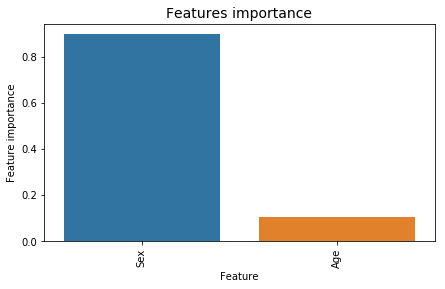

In [91]:
plot_feature_importance()

<a href="#0"><font size="1">Go to top</font></a>  


## <a id='52'>Evaluate the model</a>  

Let's evaluate the model performance. 

We are evaluating first the accuracy for the train set.



In [92]:
clf.score(train_X, train_Y)
acc = round(clf.score(train_X, train_Y) * 100, 2)
print("RandomForest accuracy (train set):", acc)

RandomForest accuracy (train set): 77.81


The result means that the total number of correct predictions divided by the total number of examples in the training set is around 0.77. Because we have a binary classification, this means:

$$Accuracy =\frac{ \textrm{True Positives} + \textrm{True Negatives}}{\textrm{Number of Examples}}$$ 


Then we evaluate the accuracy for the validation set. 

In [93]:
clf.score(valid_X, valid_Y)
acc = round(clf.score(valid_X, valid_Y) * 100, 2)
print("RandomForest accuracy (validation set):", acc)

RandomForest accuracy (validation set): 82.12


The accuracy for the validation is much better than the accuracy for the training set. 
This means we have higher bias than variation. The model does not learn too well the training set, we are not overfitting (yet). The validation is better, i.e. we are generalizing well. Before improving the variation, we will try to improve the bias, while looking how this affects the variation as well.

Let's plot now the classification report for validation data.

In [94]:
print(metrics.classification_report(valid_Y, preds, target_names=['Not Survived', 'Survived']))

              precision    recall  f1-score   support

Not Survived       0.84      0.89      0.86       115
    Survived       0.78      0.70      0.74        64

   micro avg       0.82      0.82      0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.82      0.82      0.82       179



There are few values given in this report / each category in the target (`Survived` or `Not survived`):

* **Precision**  
* **Recall**  
* **F1-score**  

Let's explain each of them:

* **Precision** identifies the frequency with which a model was correct when predicting the positive class. That is:

$$Precision = \frac{\textrm{True Positives}}{\textrm{True Positives} + \textrm{False Positives}}$$

* **Recall** answers the following question: Out of all the possible positive labels, how many did the model correctly identify? That is:

$$Recall = \frac{\textrm{True Positives}}{\textrm{True Positives} + \textrm{False Negatives}}$$

* **F1-score** is the harmonic mean of **precision** and **recall**.

$$\textrm{F1-score} = 2  \frac{Precision * Recall}{Precision + Recall}$$


Precison is better for the `Not survived` as well as Recall and F1-score.

Let's also show the confusion matrix.

In [95]:
def plot_confusion_matrix():
    cm = pd.crosstab(valid_Y, preds, rownames=['Actual'], colnames=['Predicted'])
    fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
    sns.heatmap(cm, 
                xticklabels=['Not Survived', 'Survived'],
                yticklabels=['Not Survived', 'Survived'],
                annot=True,ax=ax1,
                linewidths=.2,linecolor="Darkblue", cmap="Blues")
    plt.title('Confusion Matrix', fontsize=14)
    plt.show()

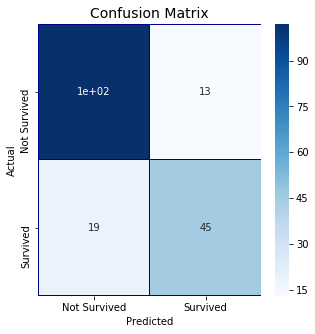

In [96]:
plot_confusion_matrix()

<a href="#0"><font size="1">Go to top</font></a>  

## <a id='53'>Model refinement</a> 

Let's rebuild the model and add more features to it.

### Model with {Sex, Age, Pclass, Fare} features

In [97]:
predictors = ['Sex', 'Age', 'Pclass', 'Fare']
target = 'Survived'

In [98]:
train_X = train[predictors]
train_Y = train[target].values
valid_X = valid[predictors]
valid_Y = valid[target].values

We fit the model.

In [99]:
clf.fit(train_X, train_Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False, random_state=2018, verbose=False,
            warm_start=False)

We predict the validation set.

In [100]:
preds = clf.predict(valid_X)

Let's plot feature importance.

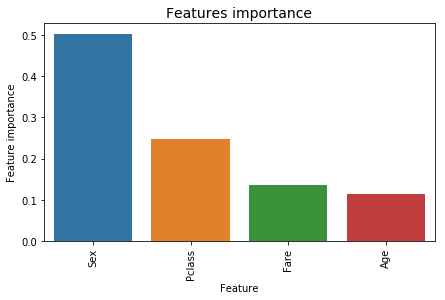

In [101]:
plot_feature_importance()

Let's see the accuracy for the training set and for the validation set.

In [102]:
clf.score(train_X, train_Y)
acc = round(clf.score(train_X, train_Y) * 100, 2)
print("RandomForest accuracy (train set):", acc)

RandomForest accuracy (train set): 82.44


In [103]:
clf.score(valid_X, valid_Y)
acc = round(clf.score(valid_X, valid_Y) * 100, 2)
print("RandomForest accuracy (validation set):", acc)

RandomForest accuracy (validation set): 85.47


Let's see also the classification report for the validation set.

In [104]:
print(metrics.classification_report(valid_Y, preds, target_names=['Not Survived', 'Survived']))

              precision    recall  f1-score   support

Not Survived       0.85      0.94      0.89       115
    Survived       0.87      0.70      0.78        64

   micro avg       0.85      0.85      0.85       179
   macro avg       0.86      0.82      0.83       179
weighted avg       0.86      0.85      0.85       179



Here we plot the confusion matrix.

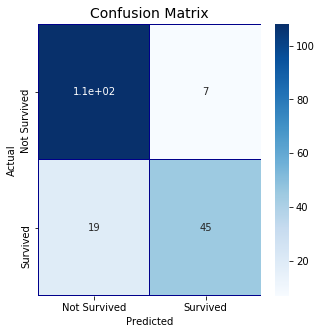

In [105]:
plot_confusion_matrix()

The model performance with train data improved, i.e. the model is now representing better the training set.  The accuracy and precision with the validation set was as well improved. The recall and f1-score are smaller for `Survived`. 

Let's repeat the experiment adding more features.

### Model with {Sex, Age, Pclass, Fare, Parch, SibSp} features

In [106]:
predictors = ['Sex', 'Age', 'Pclass', 'Fare', 'Parch', 'SibSp']
target = 'Survived'

In [107]:
train_X = train[predictors]
train_Y = train[target].values
valid_X = valid[predictors]
valid_Y = valid[target].values

Let's fit the model with the new predictors.

In [108]:
clf.fit(train_X, train_Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False, random_state=2018, verbose=False,
            warm_start=False)

We predict the validation set.

In [109]:
preds = clf.predict(valid_X)

We plot the feature importance.

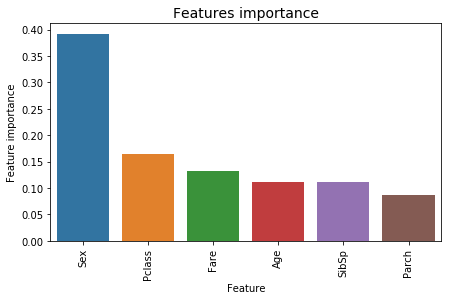

In [110]:
plot_feature_importance()

**Sex** is the dominant feature, followed by **Pclass** and **Fare**.  
Let's see the accuracy for the training set and also for the validation set classification.

In [111]:
clf.score(train_X, train_Y)
acc = round(clf.score(train_X, train_Y) * 100, 2)
print("RandomForest accuracy (train set):", acc)

RandomForest accuracy (train set): 86.66


In [112]:
clf.score(valid_X, valid_Y)
acc = round(clf.score(valid_X, valid_Y) * 100, 2)
print("RandomForest accuracy (validation set):", acc)

RandomForest accuracy (validation set): 83.24


Let's also plot the classification report for the validation set.

In [113]:
print(metrics.classification_report(valid_Y, preds, target_names=['Not Survived', 'Survived']))

              precision    recall  f1-score   support

Not Survived       0.88      0.86      0.87       115
    Survived       0.76      0.78      0.77        64

   micro avg       0.83      0.83      0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



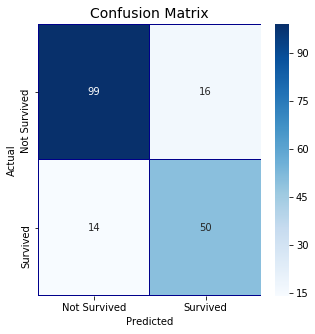

In [114]:
plot_confusion_matrix()

The accuracy for the train data classification improved further but the accuracy and precision for validation did not improved.    

Let's add few more engineering features.


### Model with {Sex, Age, Pclass, Fare, Parch, SibSp, FamilySize, Title} features

In [115]:
predictors = ['Sex', 'Age', 'Pclass', 'Fare', 'Parch', 'SibSp', 'FamilySize', 'Title']
target = 'Survived'

In [116]:
train_X = train[predictors]
train_Y = train[target].values
valid_X = valid[predictors]
valid_Y = valid[target].values

Let's fit the model with the new data.

In [117]:
clf.fit(train_X, train_Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False, random_state=2018, verbose=False,
            warm_start=False)

We predict the validation set.

In [118]:
preds = clf.predict(valid_X)

Let's plot also the feature importance.

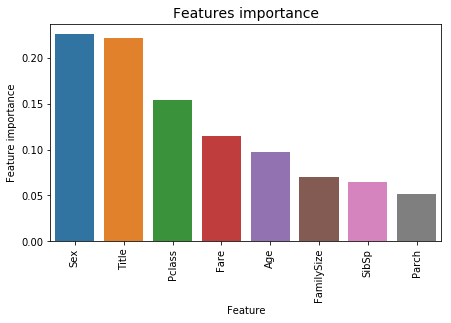

In [119]:
plot_feature_importance()

Let's see the train set and validation set classification accuracy.

In [120]:
clf.score(train_X, train_Y)
acc = round(clf.score(train_X, train_Y) * 100, 2)
print("RandomForest accuracy (train set):", acc)

RandomForest accuracy (train set): 87.92


In [121]:
clf.score(valid_X, valid_Y)
acc = round(clf.score(valid_X, valid_Y) * 100, 2)
print("RandomForest accuracy (validation set):", acc)

RandomForest accuracy (validation set): 81.56


The classification report for the validation set.

In [122]:
print(metrics.classification_report(valid_Y, preds, target_names=['Not Survived', 'Survived']))

              precision    recall  f1-score   support

Not Survived       0.85      0.86      0.86       115
    Survived       0.75      0.73      0.74        64

   micro avg       0.82      0.82      0.82       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.82      0.82      0.82       179



The confusion matrix.

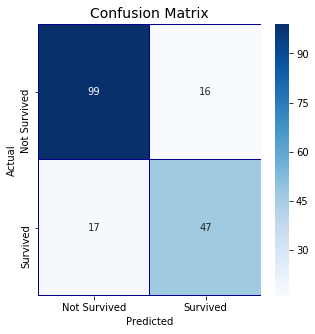

In [123]:
plot_confusion_matrix()

The training set accuracy improved even more. In the same time, validation score is not very much improved. This indicates that most probably the model where we added more features is overfitting on the training set. Actually, the best model obtained until now was the one with {Sex, Age, Pclass, Fare} features, where accuracies for training set and validation set were 82% and 86% (with quite good precision for all categories and small recall for `Survived`).

Let's try with a simpler model.


### Model with {Title, FamilySize, Pclass} features

The simple model we will try now, with only three features, is actually using only engineered features.

In [124]:
predictors = ['FamilySize', 'Title', 'Class*Age']
target = 'Survived'

In [125]:
train_X = train[predictors]
train_Y = train[target].values
valid_X = valid[predictors]
valid_Y = valid[target].values

We fit the model.

In [126]:
rf_clf = clf.fit(train_X, train_Y)

Let's plot the parameters for the classifier.

In [127]:
rf_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False, random_state=2018, verbose=False,
            warm_start=False)

We predict the validation set.

In [128]:
preds = clf.predict(valid_X)

We check the features importance.

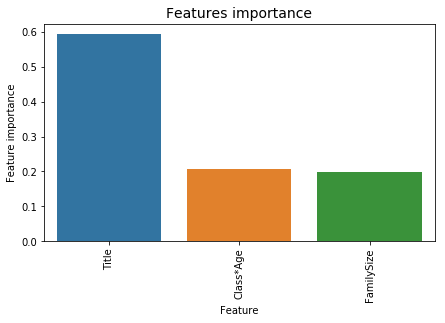

In [129]:
plot_feature_importance()

In [130]:
clf.score(train_X, train_Y)
acc = round(clf.score(train_X, train_Y) * 100, 2)
print("RandomForest accuracy (train set):", acc)

RandomForest accuracy (train set): 82.58


In [131]:
clf.score(valid_X, valid_Y)
acc = round(clf.score(valid_X, valid_Y) * 100, 2)
print("RandomForest accuracy (validation set):", acc)

RandomForest accuracy (validation set): 86.59


The training set classification accuracy is still good, although lower than that of the previous, more complex model.
The validation set accuracy is the best obtained until now.

**Title** is the most important feature.  

Let's check now the classification report for the validation set.

In [132]:
print(metrics.classification_report(valid_Y, preds, target_names=['Not Survived', 'Survived']))

              precision    recall  f1-score   support

Not Survived       0.88      0.92      0.90       115
    Survived       0.84      0.77      0.80        64

   micro avg       0.87      0.87      0.87       179
   macro avg       0.86      0.84      0.85       179
weighted avg       0.86      0.87      0.86       179



We see that we obtained an substantial improvement of the classification precision for the validation set.   Also the recall is better than in the case of the model with best accuracy and precision until now, besides this one.

Let's also plot the confusion matrix.

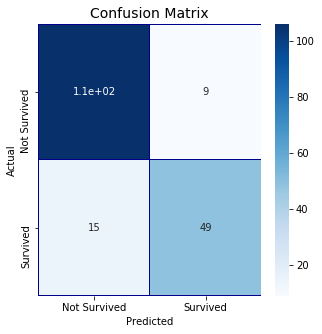

In [133]:
plot_confusion_matrix()

We will pick this last model for submission.
It doesn't have the best accuracy for train set classification but have one of the best precision and accuracy for the validation set and also the smallest recall. 

Let's prepare the submission.

<a href="#0"><font size="1">Go to top</font></a>  

## <a id='54'>Submission</a>


First, we predict for test data using the trained model.

In [134]:
test_X = test_df[predictors]
pred_Y = clf.predict(test_X)

Then, we prepare the submission dataset and export it in the submission file.

In [135]:
submission = pd.DataFrame({"PassengerId": test_df["PassengerId"],"Survived": pred_Y})
submission.to_csv('submission.csv', index=False)

The precision obtained for the test set is approx. **0.79**.

<a href="#0"><font size="1">Go to top</font></a>  

## <a id='55'>Hyperparameters optimization</a>


Let's continue with tunning the model hyperparameters.   
We define a set of parameters with several values and will run an algorithm called Gradient Search to detect the best combination of parameters for our model.  
First, let's fit the model and assign the output of it to **rf_clf**.

In [136]:
rf_clf = clf.fit(train_X, train_Y)

Let's initialize the GradientSearchCV parameters. We will set only few parameters, as following:

* **n_estimators**: number of trees in the foreset;  
* **max_features**: max number of features considered for splitting a node;  
* **max_depth**: max number of levels in each decision tree;  
* **min_samples_split**: min number of data points placed in a node before the node is split;  
* **min_samples_leaf**: min number of data points allowed in a leaf node.


In [137]:
parameters = {
    'n_estimators': (50, 75,100),
    'max_features': ('auto', 'sqrt'),
    'max_depth': (3,4,5),
    'min_samples_split': (2,5,10),
    'min_samples_leaf': (1,2,3)
}

We initialize GridSearchCV with the classifier, the set of parameters, number of folds and also the level of verbose for printing out progress.

In [138]:
%%time
gs_clf = GridSearchCV(rf_clf, parameters, n_jobs=-1, cv = 5, verbose = 5)
gs_clf = gs_clf.fit(train_X, train_Y)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.3min


CPU times: user 4.41 s, sys: 266 ms, total: 4.67 s
Wall time: 1min 35s


[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  1.6min finished


Let's see the best parameters.

In [139]:
print('Best scores:',gs_clf.best_score_)
print('Best params:',gs_clf.best_params_)

Best scores: 0.8132022471910112
Best params: {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}


Let's predict with the validation data.

In [140]:
preds = gs_clf.predict(valid_X)

Let's check the accuracy for the validation set.

In [141]:
clf.score(valid_X, valid_Y)
acc = round(clf.score(valid_X, valid_Y) * 100, 2)
print("RandomForest accuracy (validation set):", acc)

RandomForest accuracy (validation set): 86.59


Let's check the validation classification report.

In [142]:
print(metrics.classification_report(valid_Y, preds, target_names=['Not Survived', 'Survived']))

              precision    recall  f1-score   support

Not Survived       0.88      0.92      0.90       115
    Survived       0.84      0.77      0.80        64

   micro avg       0.87      0.87      0.87       179
   macro avg       0.86      0.84      0.85       179
weighted avg       0.86      0.87      0.86       179



## <a id='56'>Submission (model with hyperparameters optimization)</a>


First, we predict for test data using the trained model.


In [143]:
test_X = test_df[predictors]
pred_Y = gs_clf.predict(test_X)

Then we prepare the submission dataset and save it to the submission file.

In [144]:
submission = pd.DataFrame({"PassengerId": test_df["PassengerId"],"Survived": pred_Y})
submission.to_csv('submission_hyperparam_optimization.csv', index=False)

<a href="#0"><font size="1">Go to top</font></a>  


# <a id='6'>Model ensambling</a>


Let's continue with creation of second level models. We will train several models and will then use these first level models to train a second level model. This method is powerfull and can enhance the performance of first level models, especially when there is little correlation between the results of first level models.


## <a id='61'>Create the ensamble framework</a>


We start by creating a generic classifier, that extends the functionality of a simple classifier. This generic classifier will be instanciated with few different first level classifiers and then used in the ensamble. We are also using cross-validation (with KFolds).

First step will be to create the folds used in cross validation.

In [145]:
NUMBER_KFOLDS = 5
kf = KFold(n_splits = NUMBER_KFOLDS, random_state = RANDOM_STATE, shuffle = True)

In [146]:
# Class to extend the Sklearn classifier
class SklearnBasicClassifier(object):
    def __init__(self, clf, seed=2018, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

    def get_feature_importances(self,x,y):
        return (self.clf.fit(x,y).feature_importances_)


## <a id='62'>Create the Out-of-Fold Predictions</a>

Let's now define out-of-folds predictions. If we would train the base models on the full training data and generate predictions on the full test set and then output these for the second-level training we might go into trouble. The risk here is that the base model predictions would have seen the test set and thus overfitting when feeding those predictions.

In [147]:
ntrain = train_df.shape[0]
ntest = test_df.shape[0]
def get_oof_predictions(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NUMBER_KFOLDS, ntest))
    
    for i, (train_idx, valid_idx) in enumerate(kf.split(train_df)):
        clf.train(x_train[train_idx], y_train[train_idx])
        oof_train[valid_idx] = clf.predict(x_train[valid_idx])
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

## <a id='63'>Train the first level models</a>  


Let's define and train few first level models.

We will use the following first level models:


* AdaBoost classifer
* CatBoost Classifier
* Extra Trees classifier  
* Gradient Boosting classifer
* Random Forest classifier  
* Support Vector Machine


Let's define the parameters used for training each classifier:

In [148]:
# AdaBoost parameters
ada_params = {
    'n_estimators': 200,
    'learning_rate' : 0.75
}
# CatBoost parameters
cat_params = {
    'iterations': 150,
    'learning_rate': 0.02,
    'depth': 12,
    'bagging_temperature':0.2,
    'od_type':'Iter',
    'metric_period':400,
}  
# Extra Trees Parameters
ext_params = {
    'n_jobs': -1,
    'n_estimators':100,
    'max_depth': 8,
    'min_samples_leaf': 3,
    'verbose': 0
}
# Gradient Boosting parameters
gbm_params = {
    'n_estimators': 200,
    'max_depth': 5,
    'min_samples_leaf': 3,
    'verbose': 0
}
# Random Forest parameters
rfo_params = {
    'n_jobs': -1,
    'n_estimators': 50,
    'max_depth': 5,
    'min_samples_leaf': 5,
    'max_features' : 'auto',
    'verbose': 0
}
# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.02
}

We create 6 objects of type `SklearnBasicClassifier` that represent our 6 models(AdaBoost, CatBoost, ExtraTrees, GradientBoosting, RandomForest and Support Vector Machines).

In [149]:
# Create 6 objects that represent our 6 models
ada = SklearnBasicClassifier(clf=AdaBoostClassifier, seed=RANDOM_STATE, params=ada_params)
cat = SklearnBasicClassifier(clf=CatBoostClassifier, seed=RANDOM_STATE, params=cat_params)
ext = SklearnBasicClassifier(clf=ExtraTreesClassifier, seed=RANDOM_STATE, params=ext_params)
gbm = SklearnBasicClassifier(clf=GradientBoostingClassifier, seed=RANDOM_STATE, params=gbm_params)
rfo = SklearnBasicClassifier(clf=RandomForestClassifier, seed=RANDOM_STATE, params=rfo_params)
svc = SklearnBasicClassifier(clf=SVC, seed=RANDOM_STATE, params=svc_params)

In [150]:
predictors = ['FamilySize', 'Title', 'Class*Age']
target = 'Survived'

In [151]:
y_train = train_df['Survived'].values
train = train_df[predictors]
test = test_df[predictors]
x_train = train.values
x_test = test.values

In [152]:
print("Start training")
ada_oof_train, ada_oof_test = get_oof_predictions(ada, x_train, y_train, x_test) # AdaBoost Classifier
print("End AdaBoost")
cat_oof_train, cat_oof_test = get_oof_predictions(cat, x_train, y_train, x_test) # CatBoost Classifier
print("End CatBoost")
ext_oof_train, ext_oof_test = get_oof_predictions(ext, x_train, y_train, x_test) # Extra Trees 
print("End ExtraTrees")
rfo_oof_train, rfo_oof_test = get_oof_predictions(rfo,x_train, y_train, x_test) # Random Forest Classifier
print("End RandomForest")
gbm_oof_train, gbm_oof_test = get_oof_predictions(gbm,x_train, y_train, x_test) # Gradient Boost Classifier
print("End GradientBoost")
svc_oof_train, svc_oof_test = get_oof_predictions(svc,x_train, y_train, x_test) # Support Vector Classifier
print("End training")

Start training
End AdaBoost
0:	learn: 0.6823816	total: 68.7ms	remaining: 10.2s
149:	learn: 0.4304547	total: 1.63s	remaining: 0us
0:	learn: 0.6837343	total: 7.78ms	remaining: 1.16s
149:	learn: 0.4247339	total: 1.33s	remaining: 0us
0:	learn: 0.6827445	total: 7.69ms	remaining: 1.15s
149:	learn: 0.3955411	total: 1.39s	remaining: 0us
0:	learn: 0.6831206	total: 8.46ms	remaining: 1.26s
149:	learn: 0.4118386	total: 1.44s	remaining: 0us
0:	learn: 0.6824008	total: 8.39ms	remaining: 1.25s
149:	learn: 0.4006063	total: 1.49s	remaining: 0us
End CatBoost
End ExtraTrees
End RandomForest
End GradientBoost
End training


Let's check the features importance for the 5 out of 6 models. We will not include Support Vector Classifier, this one does not have feature importance available.

In [153]:
ada_feature_importance = ada.get_feature_importances(x_train,y_train)
cat_feature_importance = cat.get_feature_importances(x_train,y_train)
ext_feature_importance = ext.get_feature_importances(x_train,y_train)
gbm_feature_importance = gbm.get_feature_importances(x_train,y_train)
rfo_feature_importance = rfo.get_feature_importances(x_train,y_train)

0:	learn: 0.6831021	total: 8.63ms	remaining: 1.29s
149:	learn: 0.4125944	total: 1.33s	remaining: 0us


In [154]:
def plot_feature_importance(feature_importance, classifier):
    tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': feature_importance[0:len(predictors)]})
    tmp = tmp.sort_values(by='Feature importance',ascending=False)
    plt.figure(figsize = (7,4))
    plt.title('Features importance {}'.format(classifier),fontsize=14)
    s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show()   

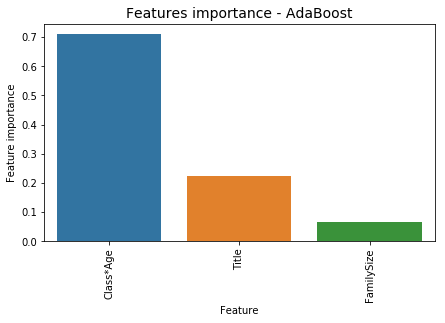

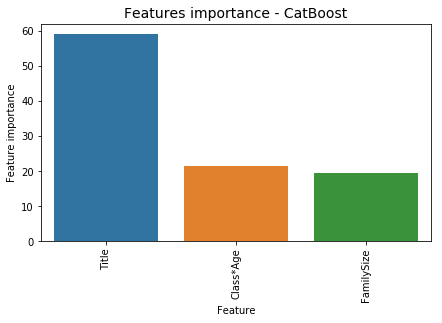

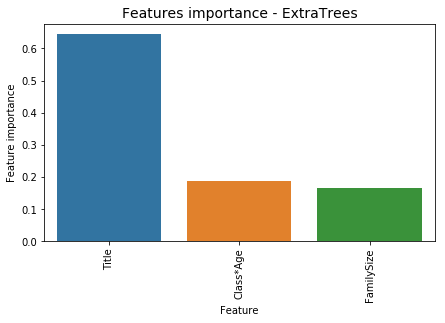

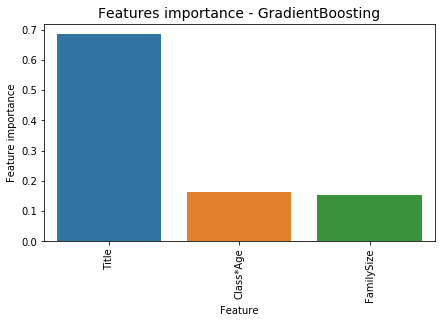

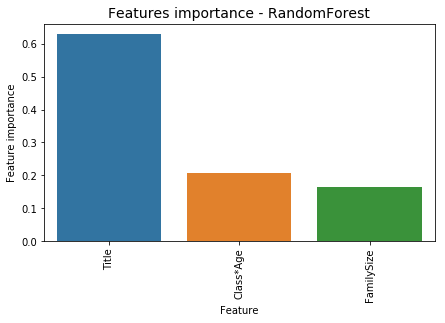

In [155]:
plot_feature_importance(ada_feature_importance, '- AdaBoost')
plot_feature_importance(cat_feature_importance, '- CatBoost')
plot_feature_importance(ext_feature_importance, '- ExtraTrees')
plot_feature_importance(gbm_feature_importance, '- GradientBoosting')
plot_feature_importance(rfo_feature_importance, '- RandomForest')

## <a id='64'>Correlation of the results</a>

Let's see the first few results of the predictions using first level models.

In [156]:
base_predictions_train = pd.DataFrame( {
     'AdaBoost': ada_oof_train.ravel(),
     'CatBoost': cat_oof_train.ravel(),
     'ExtraTrees': ext_oof_train.ravel(),
     'GradientBoost': gbm_oof_train.ravel(),
     'RandomForest': rfo_oof_train.ravel(),
     'SVM': svc_oof_train.ravel()
    })
base_predictions_train.head(10)

,AdaBoost,CatBoost,ExtraTrees,GradientBoost,RandomForest,SVM
0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,1.0
8,1.0,1.0,1.0,1.0,1.0,1.0
9,1.0,1.0,1.0,1.0,1.0,1.0


Let's show now the correlation of the predictions using the first level models. The ensamble prediction is best when we have models with good accuracy and less correlated.

In [157]:
trace = go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Rainbow',
            showscale=True,
            reversescale = False
    )
data = [trace]
layout = dict(width = 600, height=600)
fig = dict(data=data, layout=layout)
iplot(fig, filename='heatmap')

## <a id='65'>Build the second level (ensamble) model</a>


We prepare now, using the Out-Of-Folds values, the training and the test set for the second level model. We concatenate the OOFs from the 6 first level models.

In [158]:
x_train = np.concatenate(( ada_oof_train, cat_oof_train, ext_oof_train, gbm_oof_train, rfo_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( ada_oof_test, cat_oof_test, ext_oof_test, gbm_oof_test, rfo_oof_test, svc_oof_test), axis=1)

We prepare as well the second level classifier. 

We will use in this case a eXtreme Boost Classifier.

In [159]:
clf = xgb.XGBClassifier(
 learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1)

We fit the model.

In [160]:
xgbm = clf.fit(x_train, y_train)

With the fitted second level model we do the prediction for the test data.

In [161]:
predictions = xgbm.predict(x_test)

## <a id='66'>Submission (ensamble)</a>

We form the submission dataset and save it to the submission file.

In [162]:
submissionStacking = pd.DataFrame({ 'PassengerId': test_df["PassengerId"],'Survived': predictions })
submissionStacking.to_csv("submission_ensamble.csv", index=False)

<a href="#0"><font size="1">Go to top</font></a>  



# <a id='7'>References</a>

[1] https://www.kaggle.com/startupsci/titanic-data-science-solutions  
[2] https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python  
[3] https://www.kaggle.com/gpreda/credit-card-fraud-detection-predictive-models  
[4] https://www.kaggle.com/gpreda/honey-bee-subspecies-classification  